<a href="https://colab.research.google.com/github/nescoba/portafolio/blob/main/diagnostics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# pip install itscalledsoccer

     |████████████████████████████████| 893 kB 28.4 MB/s 
     |████████████████████████████████| 61 kB 9.3 MB/s 
     |████████████████████████████████| 11.5 MB 36.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
  Attempting uninstall: CacheControl
    Found existing installation: CacheControl 0.12.10
    Uninstalling CacheControl-0.12.10:
      Successfully uninstalled CacheControl-0.12.10
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.25.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have f

In [4]:
from itscalledsoccer.client import AmericanSoccerAnalysis

asa_client = AmericanSoccerAnalysis() 

asa_client.get_teams(leagues='mls')

Gathering all players
Gathering all teams
Gathering all stadia
Gathering all managers
Gathering all referees
Finished initializing client


,team_id,team_name,team_short_name,team_abbreviation,competition
0,0KPqjA456v,San Jose Earthquakes,San Jose,SJE,mls
1,19vQ2095K6,New England Revolution,New England,NER,mls
2,4wM42l4qjB,Chivas USA,Chivas,CHV,mls
3,9z5k7Yg5A3,Philadelphia Union,Philadelphia,PHI,mls
4,a2lqR4JMr0,Real Salt Lake,Salt Lake,RSL,mls
5,a2lqRX2Mr0,New York Red Bulls,New York,NYRB,mls
6,APk5LGOMOW,CF Montréal,Montréal,MTL,mls
7,EKXMeX3Q64,D.C. United,D.C. United,DCU,mls
8,eVq3ya6MWO,Los Angeles FC,Los Angeles FC,LAFC,mls
9,gpMOLwl5zy,Austin FC,Austin,ATX,mls


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 
sns.set()


In [6]:
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
def construct_time_series_date(team_id, date):
    seasons = asa_client.get_game_xgoals(leagues='mls')
    seasons.loc[:, 'date_formated'] = pd.to_datetime(seasons['date_time_utc'])
    seasons = seasons[seasons['date_formated'] < date]

    seasons_team = seasons[(seasons['home_team_id']==team_id) | (seasons['away_team_id']==team_id)]
    team_home = seasons_team[seasons_team['home_team_id']==team_id]
    team_away = seasons_team[seasons_team['away_team_id']==team_id]

    team_home.loc[:,'teamxgoals'] = team_home['home_team_xgoals']
    team_away.loc[:,'teamxgoals'] = team_away['away_team_xgoals']

    team_home.loc[:,'teamgoals'] = team_home['home_goals']
    team_away.loc[:,'teamgoals'] = team_away['away_goals']

    team_home.loc[:,'oppoxgoals'] = team_home['away_team_xgoals']
    team_away.loc[:,'oppoxgoals'] = team_away['home_team_xgoals']

    team_home.loc[:,'oppogoals'] = team_home['away_goals']
    team_away.loc[:,'oppogoals'] = team_away['home_goals']

    team_home_red = team_home.loc[:, ['teamgoals', 'teamxgoals', 'oppoxgoals', 'oppogoals', 'date_formated']]
    team_away_red = team_away.loc[:, ['teamgoals', 'teamxgoals', 'oppoxgoals', 'oppogoals', 'date_formated']]

    team_red = pd.merge(team_home_red, team_away_red, how='outer')

    team_red = team_red.sort_values(by='date_formated')

    return team_red

In [8]:
def probs_game(home_id, away_id, date, arg):
    home_df = construct_time_series_date(home_id, pd.to_datetime(date))
    away_df = construct_time_series_date(away_id, pd.to_datetime(date))

    hteam_series = pd.Series(home_df['teamxgoals'].values, index=home_df['date_formated'])

    try:
        hmod = sm.tsa.ARIMA(hteam_series, order = (0,1,1))
        hres = hmod.fit()
        hlambda = hres.predict(start=(len(hteam_series)), end=(len(hteam_series)+0)).values
    except:
        try:
            hlambda = home_df.loc[len(home_df) -1 ,'teamxgoals']
        except:
            hlambda = 0.01


    ateam_series = pd.Series(away_df['teamxgoals'].values, index=away_df['date_formated'])
    
    try:
        amod = sm.tsa.ARIMA(ateam_series, order = (0,1,1))
        ares = amod.fit()
        alambda = ares.predict(start=(len(ateam_series)), end=(len(ateam_series)+0)).values
    except:
        try:
            alambda = away_df.loc[len(away_df) - 1, 'teamxgoals']
        except:
            alambda= 0.01


    n_simulations = 10000
    n_home = 0
    n_draw = 0
    n_away = 0

    for n in range(n_simulations):
        home_score = np.random.poisson(max(hlambda, 0.01))
        away_score = np.random.poisson(max(alambda, 0.01))
        if home_score > away_score:
            n_home += 1
        elif home_score < away_score:
            n_away += 1
        else:
            n_draw += 1 

    return (n_home / n_simulations, n_draw / n_simulations, n_away / n_simulations, arg)

In [9]:
all_games = asa_client.get_games(leagues='mls')
all_games

,game_id,date_time_utc,home_score,away_score,home_team_id,away_team_id,referee_id,stadium_id,home_manager_id,away_manager_id,expanded_minutes,season_name,matchday,attendance,knockout_game,last_updated_utc,extra_time,penalties,home_penalties,away_penalties
0,315VVxG959,2022-03-07 03:00:00 UTC,1,1,eVq3ya6MWO,WBLMvYAQxe,e7MzPKXqr0,7vQ7xbOMD1,NWMWxKe5lz,gpMOYv1qzy,100,2022,2,22102,False,2022-03-07 05:30:09 UTC,NaN,NaN,NaN,NaN
1,9z5knLXjMA,2022-03-06 21:00:00 UTC,5,1,gpMOLwl5zy,zeQZkL1MKw,jYQJnoVQGR,jYQJZDDQGR,0Oq6mNP56D,gpMOYJ7qzy,100,2022,2,20738,False,2022-03-06 23:38:24 UTC,NaN,NaN,NaN,NaN
2,KAqBD3KBMb,2022-03-06 00:30:00 UTC,0,1,NPqxKXZ59d,kaDQ0wRqEv,9z5kJ7gMA3,KXMeOR2q64,gjMNG4k5Kp,Xj5Yx60Mbd,100,2022,2,74479,False,2022-03-07 03:55:19 UTC,NaN,NaN,NaN,NaN
3,e7Mz8VGGqr,2022-03-05 23:00:00 UTC,1,1,kRQand1MKZ,vzqoOgNqap,gjMNk4v5Kp,odMXGRrQYL,OlMlYvy5Lz,gOMnDkAqwN,96,2022,2,0,False,2022-03-07 01:57:19 UTC,NaN,NaN,NaN,NaN
4,eVq3gvKVqW,2022-03-05 23:00:00 UTC,1,0,a2lqR4JMr0,jYQJ19EqGR,7VqG6KX5vW,e7MzlRjqr0,4wM4vOAqjB,odMXxreMYL,95,2022,2,20017,False,2022-03-06 03:22:17 UTC,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429,xW5pyO8Jqg,2013-03-03 03:30:00 UTC,0,1,jYQJ19EqGR,APk5LGOMOW,zeQZl7D5Kw,9Yqda07QvJ,KXMeab1M64,315VKkEq9x,101,2013,1,38998,False,NaN,NaN,NaN,NaN,NaN
430,KPqjK3VYQ6,2013-03-03 01:30:00 UTC,1,0,mKAqBBmqbg,pzeQZ6xQKw,vzqoWjkqap,eVq3alGMWO,a35rDN4QL6,gjMNk8v5Kp,100,2013,1,18075,False,NaN,NaN,NaN,NaN,NaN
431,kRQaolgj5K,2013-03-03 01:00:00 UTC,2,0,YgOMngl5wN,EKXMeX3Q64,EGMPPnAMaY,0x5g6ojM7O,4JMA4X9QKg,vzqoAjJMap,95,2013,1,20019,False,NaN,NaN,NaN,NaN,NaN
432,9vQ2ZGnmQK,2013-03-02 23:30:00 UTC,1,0,lgpMOvnQzy,kRQabn8MKZ,Oa5w9R9Q14,ljqEDnO5x0,ljqEWzAMx0,gjMNk0Y5Kp,97,2013,1,21000,False,NaN,NaN,NaN,NaN,NaN


In [10]:
vprobs_game = np.vectorize(probs_game)
all_games.loc[:, 'date_formated'] = pd.to_datetime(all_games['date_time_utc'])
games = all_games[all_games['date_formated']>'2022-03-01 23:00:00 UTC']
vprobs_game(games['home_team_id'], games['away_team_id'], games['date_time_utc'], games['game_id'])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: Value

(array([0.008 , 0.0097, 0.6066, 0.3856, 0.3439, 0.2774, 0.601 , 0.0085,
        0.182 , 0.2709, 0.3571, 0.1602, 0.0089, 0.5118]),
 array([0.9824, 0.9797, 0.389 , 0.4667, 0.3174, 0.3286, 0.3949, 0.9827,
        0.8101, 0.7212, 0.4708, 0.4221, 0.979 , 0.4834]),
 array([0.0096, 0.0106, 0.0044, 0.1477, 0.3387, 0.394 , 0.0041, 0.0088,
        0.0079, 0.0079, 0.1721, 0.4177, 0.0121, 0.0048]),
 array(['315VVxG959', '9z5knLXjMA', 'KAqBD3KBMb', 'e7Mz8VGGqr',
        'eVq3gvKVqW', 'NWMWPw6E5l', 'Oa5w1RB4Q1', 'p6qbJ9mwq0',
        'XVqKBRm050', 'wvq9RAPwQW', 'jYQJ3oKkMG', 'Xj5YNBmRqb',
        'N6MmRwmx5E', 'ljqElgK45x'], dtype='<U10'))

- The question is, what to do now?
- there is the issue of taking into account how much xg does the opposition allow
- For that, the idea would be to perform similar modeling on the 'oppo' columns
- let's do it for the NYC-MTL game this saturday and everything will become clearer

- there is also the issue of how well would the model have done in past seasons?
    - how accurate are the probabilities it is outputting?
    - would it have beaten the odds? 
        - what does that even mean?






In [11]:
nyc_hist = construct_time_series_date('Vj58weDM8n', '2022-03-09')
nyc_hist

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,teamgoals,teamxgoals,oppoxgoals,oppogoals,date_formated
243,1,0.5261,0.5973,1,2015-03-08 21:00:00+00:00
119,2,2.9509,1.7539,0,2015-03-15 21:00:00+00:00
242,0,0.4476,1.1147,0,2015-03-21 20:00:00+00:00
118,0,0.8606,1.1757,1,2015-03-28 23:00:00+00:00
241,1,1.2791,1.8125,2,2015-04-11 20:00:00+00:00
...,...,...,...,...,...
124,2,1.3306,1.2536,2,2021-12-01 00:30:00+00:00
123,2,1.4296,0.5437,0,2021-12-05 20:00:00+00:00
122,1,0.9313,1.4137,1,2021-12-11 20:00:00+00:00
121,0,0.6838,1.4804,1,2022-02-27 22:00:00+00:00


In [12]:
# mod = sm.tsa.ARIMA(nyc_hist['oppoxgoals'], order = (0,1,1))
# res = mod.fit()
# print(res.summary())

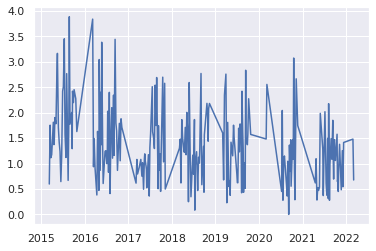

In [13]:
plt.plot(nyc_hist['date_formated'], nyc_hist['oppoxgoals'])

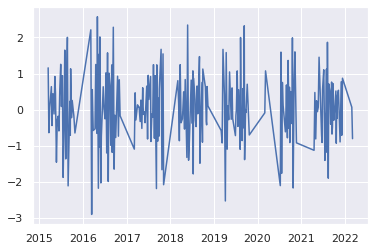

In [14]:
plt.plot(nyc_hist['date_formated'][1:], nyc_hist['oppoxgoals'].diff()[1:])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


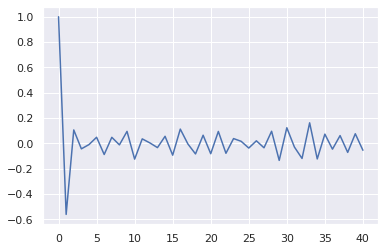

In [15]:
nyc_oppo_1 = nyc_hist['oppoxgoals'].diff()[1:]
plt.plot(sm.tsa.stattools.acf(nyc_oppo_1))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


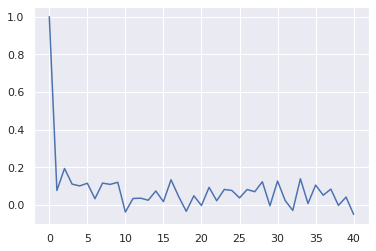

In [16]:
plt.plot(sm.tsa.stattools.acf(nyc_hist['oppoxgoals']))

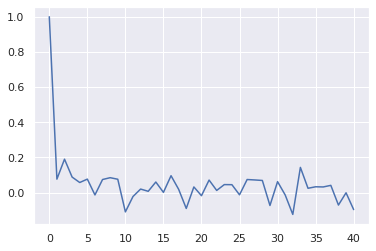

In [17]:
plt.plot(sm.tsa.stattools.pacf(nyc_hist['oppoxgoals']))

- this data suggests that the autocorrelation in the differenciated series is a complete mirage. The expected goals seem to be uncorrelated to what happens in previous games, it seems to be completely random 
- it can't be all that random, considering the ARIMA process did find significance in the MA coefficient.  

In [18]:
mod = sm.tsa.ARIMA(nyc_hist['oppoxgoals'], order = (0,0,5))
res = mod.fit()
print(res.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:             oppoxgoals   No. Observations:                  244
Model:                     ARMA(0, 5)   Log Likelihood                -266.540
Method:                       css-mle   S.D. of innovations              0.721
Date:                Wed, 09 Mar 2022   AIC                            547.081
Time:                        19:37:19   BIC                            571.561
Sample:                             0   HQIC                           556.940
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.3447      0.065     20.657      0.000       1.217       1.472
ma.L1.oppoxgoals     0.0463      0.064      0.719      0.473      -0.080       0.173
ma.L2.oppoxgoals     0.1682 

In [19]:
mod = sm.tsa.ARIMA(nyc_hist['oppoxgoals'], order = (0,0,3))
res = mod.fit()
print(res.summary())

                              ARMA Model Results                              
Dep. Variable:             oppoxgoals   No. Observations:                  244
Model:                     ARMA(0, 3)   Log Likelihood                -267.790
Method:                       css-mle   S.D. of innovations              0.725
Date:                Wed, 09 Mar 2022   AIC                            545.579
Time:                        19:37:19   BIC                            563.065
Sample:                             0   HQIC                           552.621
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.3454      0.059     22.744      0.000       1.229       1.461
ma.L1.oppoxgoals     0.0396      0.064      0.616      0.538      -0.086       0.166
ma.L2.oppoxgoals     0.1548 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [20]:
mod = sm.tsa.ARIMA(nyc_hist['oppoxgoals'], order = (0,0,1))
res = mod.fit()
print(res.summary())

                              ARMA Model Results                              
Dep. Variable:             oppoxgoals   No. Observations:                  244
Model:                     ARMA(0, 1)   Log Likelihood                -272.188
Method:                       css-mle   S.D. of innovations              0.738
Date:                Wed, 09 Mar 2022   AIC                            550.377
Time:                        19:37:19   BIC                            560.868
Sample:                             0   HQIC                           554.602
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.3460      0.050     26.974      0.000       1.248       1.444
ma.L1.oppoxgoals     0.0560      0.055      1.017      0.310      -0.052       0.164
                            

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [21]:
mod = sm.tsa.ARIMA(nyc_hist['oppoxgoals'], order = (0,1,5))
res = mod.fit()
print(res.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ValueError: ignored

In [22]:
mod = sm.tsa.ARIMA(nyc_hist['oppoxgoals'], order = (0,1,3))
res = mod.fit()
print(res.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ValueError: ignored

In [23]:
mod = sm.tsa.ARIMA(nyc_hist['oppoxgoals'], order = (0,1,1))
res = mod.fit()
print(res.summary())

                             ARIMA Model Results                              
Dep. Variable:           D.oppoxgoals   No. Observations:                  243
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -264.184
Method:                       css-mle   S.D. of innovations              0.710
Date:                Wed, 09 Mar 2022   AIC                            534.367
Time:                        19:37:44   BIC                            544.847
Sample:                             1   HQIC                           538.588
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0030      0.001     -4.719      0.000      -0.004      -0.002
ma.L1.D.oppoxgoals    -1.0000      0.014    -71.784      0.000      -1.027      -0.973
                    

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [24]:
np.sqrt(np.mean(np.square(res.resid)))

0.718520963679355

- these are not good estimates
- you can say, well:
    - of course these are unpredictible in their present form
    - this model doesn't know anything about the strength of the opposition 
    - still, there is a pattern in that the mean, right?

In [25]:
nyc_hist['oppoxgoals'].rolling(5)

Rolling [window=5,center=False,axis=0,method=single]

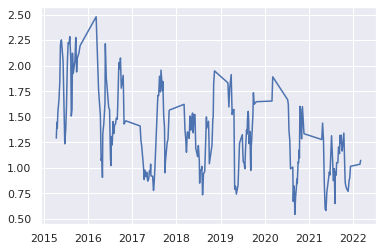

In [26]:
roll5 = sm.tsa.filters.convolution_filter(nyc_hist['oppoxgoals'], np.repeat(1/5, 5), nsides=1)
plt.plot(nyc_hist['date_formated'][:], roll5)

- so, there is a pattern
- more precisely, there is a trend, which justiffies differentiating 

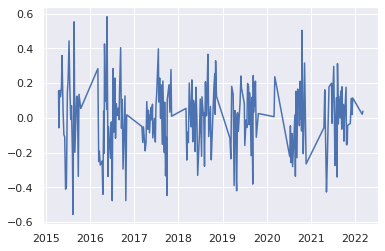

In [27]:
roll5 = sm.tsa.filters.convolution_filter(nyc_hist['oppoxgoals'].diff()[1:], np.repeat(1/5, 5), nsides=1)
plt.plot(nyc_hist['date_formated'][1:], roll5)

- indeed, no trend after differentiating

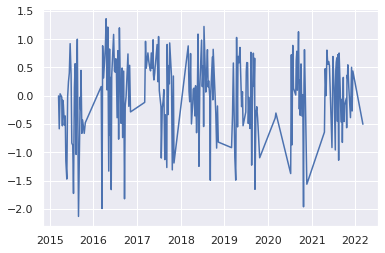

In [28]:
plt.plot(nyc_hist['date_formated'][1:], res.predict())

In [38]:
# plt.plot(nyc_hist['date_formated'][1:], res.predict())
# plt.plot(nyc_hist['date_formated'][1:], nyc_hist['oppoxgoals'][1:])

In [30]:
mod = sm.tsa.ARIMA(nyc_hist['oppoxgoals'].diff()[1:], order = (0,0,1))
res = mod.fit()
print(res.summary())

                              ARMA Model Results                              
Dep. Variable:             oppoxgoals   No. Observations:                  243
Model:                     ARMA(0, 1)   Log Likelihood                -264.184
Method:                       css-mle   S.D. of innovations              0.710
Date:                Wed, 09 Mar 2022   AIC                            534.367
Time:                        19:37:57   BIC                            544.847
Sample:                             0   HQIC                           538.588
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0030      0.001     -4.719      0.000      -0.004      -0.002
ma.L1.oppoxgoals    -1.0000      0.014    -71.784      0.000      -1.027      -0.973
                            

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [37]:
# plt.plot(nyc_hist['date_formated'][1:], np.mean(nyc_hist['oppoxgoals'][1:])+np.cumsum(res.predict()), label='predicted')
# plt.plot(nyc_hist['date_formated'][1:], nyc_hist['oppoxgoals'][1:], label='actual')
# plt.legend()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


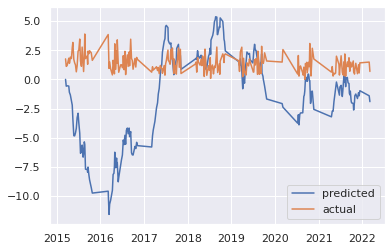

In [32]:
mod = sm.tsa.ARIMA(nyc_hist['oppoxgoals'], order = (0,1,1))
res = mod.fit()

plt.plot(nyc_hist['date_formated'][1:], np.cumsum(res.predict()), label='predicted')
plt.plot(nyc_hist['date_formated'][1:], nyc_hist['oppoxgoals'][1:], label='actual')
plt.legend()

In [39]:
# mod = sm.tsa.ARIMA(nyc_hist['oppoxgoals'], order = (0,1,1))
# res = mod.fit()

# plt.plot(nyc_hist['date_formated'][1:], np.mean(nyc_hist['oppoxgoals'][1:]) + res.predict())
# plt.plot(nyc_hist['date_formated'][1:], nyc_hist['oppoxgoals'][1:])

In [40]:
# plt.plot(nyc_hist['date_formated'][1:], res.fittedvalues)
# plt.plot(nyc_hist['date_formated'][1:], nyc_hist['oppoxgoals'][1:])

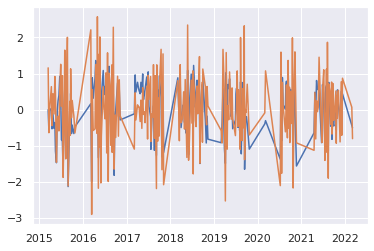

In [36]:
plt.plot(nyc_hist['date_formated'][1:], res.fittedvalues)
plt.plot(nyc_hist['date_formated'][1:], nyc_hist['oppoxgoals'].diff()[1:])


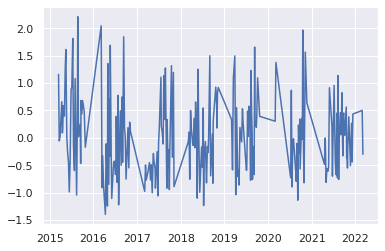

In [41]:
plt.plot(nyc_hist['date_formated'][1:], res.resid)

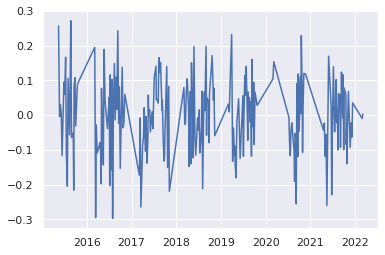

In [44]:
roll5 = sm.tsa.filters.convolution_filter(nyc_hist['oppoxgoals'].diff()[1:], np.repeat(1/10, 10), nsides=1)
plt.plot(nyc_hist['date_formated'][1:], roll5)

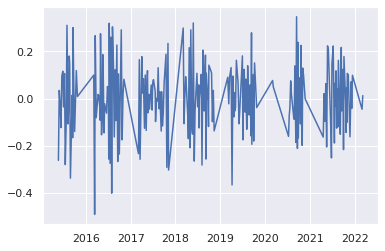

In [45]:
roll5 = sm.tsa.filters.convolution_filter(nyc_hist['oppoxgoals'].diff().diff()[2:], np.repeat(1/10, 10), nsides=1)
plt.plot(nyc_hist['date_formated'][2:], roll5)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


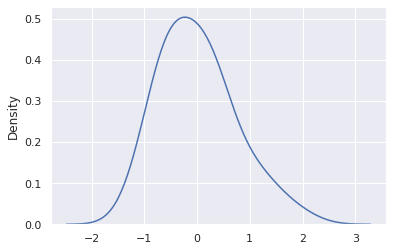

In [46]:
sns.kdeplot(res.resid, bw=0.5)

----

In [47]:
from statsmodels.tsa.stattools import adfuller

In [48]:
result = adfuller(nyc_hist['oppoxgoals'].diff()[1:])
result[1]

5.069615288538236e-16

In [49]:
result = adfuller(nyc_hist['oppoxgoals'])
result[1]

4.9992275896503365e-14

-----

In [50]:
mod = sm.tsa.ARIMA(nyc_hist['teamxgoals'], order = (0,1,1))
res = mod.fit()
print(res.summary())

                             ARIMA Model Results                              
Dep. Variable:           D.teamxgoals   No. Observations:                  243
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -280.277
Method:                       css-mle   S.D. of innovations              0.758
Date:                Wed, 09 Mar 2022   AIC                            566.554
Time:                        20:54:32   BIC                            577.033
Sample:                             1   HQIC                           570.775
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0011      0.001      1.619      0.107      -0.000       0.002
ma.L1.D.teamxgoals    -1.0000      0.013    -77.082      0.000      -1.025      -0.975
                    

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


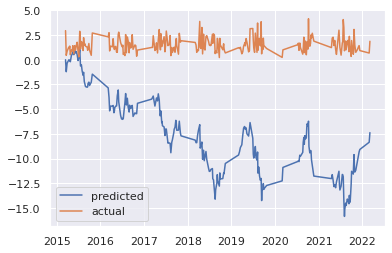

In [51]:
plt.plot(nyc_hist['date_formated'][1:], np.cumsum(res.predict()), label='predicted')
plt.plot(nyc_hist['date_formated'][1:], nyc_hist['teamxgoals'][1:], label='actual')
plt.legend()

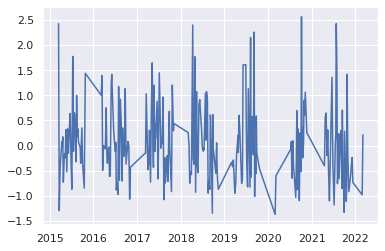

In [53]:
plt.plot(nyc_hist['date_formated'][1:], res.resid)

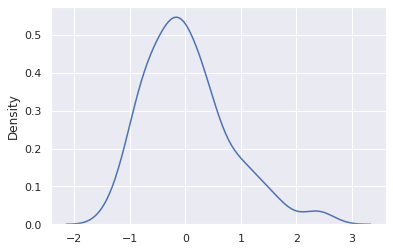

In [54]:
sns.kdeplot(res.resid)